# Final project scratchpad

## 1. Import ResNet50 model trained on VGGFace2 (from WeidiXie gihub)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread
import os

1) import code provided by VGGFace2 team @ https://drive.google.com/file/d/1AHVpuB24lKAqNyRRjhX7ABlEor6ByZlS/view
2) 


In [10]:
#os.chdir('/jupyteruser/41320362/')
# Extract meta data and/or read it into data frames
vggTestList = pd.read_csv('data/test_list.txt')
vggTrainList = pd.read_csv('data/train_list.txt')
vggIdentityList = pd.read_csv('data/identity_meta.csv',quotechar='"',skipinitialspace=True)

# Rename the image column
vggTestList = vggTestList.rename(columns={vggTestList.columns[0]:'imageid'})
vggTrainList = vggTrainList.rename(columns={vggTrainList.columns[0]:'imageid'})

In [11]:
os.getcwd()

'/jupyteruser/41320362'

In [12]:
# import ResNet50 model trained on VGGFace2 dataset

# 2 options

In [13]:
# 1) import code provided by VGGFace2 team @ https://github.com/WeidiXie/Keras-VGGFace2-ResNet50
# %run "/jupyteruser/11332722/Keras-VGGFace2-ResNet50/src/config.py"
# %run "/jupyteruser/11332722/Keras-VGGFace2-ResNet50/src/model.py"
# %run "/jupyteruser/11332722/Keras-VGGFace2-ResNet50/src/resnet.py"
# %run "/jupyteruser/11332722/Keras-VGGFace2-ResNet50/src/utils.py"

In [14]:
# OR (NOTE DOESN"T SEEM TO WORK OUT OF THE BOX - SEE COMMENTS!!!)

# 2) import code provided by VGGFace2 team @ https://drive.google.com/file/d/1AHVpuB24lKAqNyRRjhX7ABlEor6ByZlS/view
# this link came from https://github.com/WeidiXie/Keras-VGGFace2-ResNet50 (in the Model section)
#os.chdir(r"..")

%run "vggface2_Keras/tool/toolkits.py"
%run "vggface2_Keras/src/config.py"
%run "vggface2_Keras/src/resnet.py"
%run "vggface2_Keras/src/utils.py"
%run "vggface2_Keras/src/model.py" # commented out import new_layers
#%run "/jupyteruser/11332722/vggface2_Keras/src/predict.py" # commented out toolkits.initialize_GPU(args) but still didn't work

Using TensorFlow backend.


In [15]:
# load model weights obtained from https://drive.google.com/file/d/1AHVpuB24lKAqNyRRjhX7ABlEor6ByZlS/view
# this link came from https://github.com/WeidiXie/Keras-VGGFace2-ResNet50 (in the Model section)
model = Vggface2_ResNet50()

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [17]:
# load pre-trained weights
weights_file = 'vggface2_Keras/model/resnet50_softmax_dim512/weights.h5'
model.load_weights(weights_file)

In [18]:
'''
Adapted from:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
'''

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, genPath, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')
            X[i,] = np.load(genPath + ID)

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [58]:
# Prepare the VGG data labels for each image
#vggTrainTmp = vggTrain.imageid.str.split("/",expand = True).add_prefix('imageid')
#vggTestTmp = vggTest.imageid.str.split("/",expand = True).add_prefix('imageid')

# Train directory
trainDir = "data/train/"
# Get the training sample IDs from the directory in case all of the data hasn't been loaded
dirList = os.listdir(trainDir)
# Empty data frame to start from
vggTrainTmp = pd.DataFrame()
# Loop through subdirectories to get dataframe of images
for d in dirList:
    subDirList = pd.DataFrame(os.listdir(trainDir + d))
    subDirList = subDirList.rename(columns={subDirList.columns[0]:'imageid1'})
    # Add in the sample ID
    subDirList['imageid0'] = d
    # Concatenate to make a dataframe of IDs
    vggTrainTmp = pd.concat([vggTrainTmp,subDirList], axis=0, sort=False)

# Test directory
testDir = "data/test/"
# Get the training sample IDs from the directory in case all of the data hasn't been loaded
dirList = os.listdir(testDir)
# Empty data frame to start from
vggTestTmp = pd.DataFrame()
# Loop through subdirectories to get dataframe of images
for d in dirList:
    subDirList = pd.DataFrame(os.listdir(testDir + d))
    subDirList = subDirList.rename(columns={subDirList.columns[0]:'imageid1'})
    # Add in the sample ID
    subDirList['imageid0'] = d
    # Concatenate to make a dataframe of IDs
    vggTestTmp = pd.concat([vggTestTmp,subDirList], axis=0, sort=False)
    
# Merge the ID columns to assign the right labels to each image
vggIdentityTrain = pd.merge(vggIdentityList,vggTrainTmp,right_on='imageid0',left_on='Class_ID')
# Merge the ID columns to assign the right labels to each image
vggIdentityTest = pd.merge(vggIdentityList,vggTestTmp,right_on='imageid0',left_on='Class_ID')
# Create a new column with the full image name so that the IDs are equal
vggIdentityTrain['imageid'] = vggIdentityTrain['imageid0'].str.cat(vggIdentityTrain['imageid1'],sep="/")
# Create a new column with the full image name so that the IDs are equal
vggIdentityTest['imageid'] = vggIdentityTest['imageid0'].str.cat(vggIdentityTest['imageid1'],sep="/")

vggIdentityTrain['Class_ID'] = vggIdentityTrain['Class_ID'].str.rsplit('n',1)

print(vggIdentityTrain.head())

# Parameters for RGB image with dimensions 224x224
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

# Generators
#training_generator = DataGenerator(vggIdentityTrain['imageid'], vggIdentityTrain['Gender'], trainDir, **params)
#validation_generator = DataGenerator(vggIdentityTest['imageid'], vggIdentityTest['Gender'], testDir, **params)
predict_generator = DataGenerator(vggIdentityTrain['imageid'], vggIdentityTrain['Name'], testDir, **params)

     Class_ID             Name  Sample_Num  Flag Gender     imageid1 imageid0  \
0  [, 000052]   "Adam_Housley"         212     1      m  0165_02.jpg  n000052   
1  [, 000052]   "Adam_Housley"         212     1      m  0010_01.jpg  n000052   
2  [, 000052]   "Adam_Housley"         212     1      m  0183_03.jpg  n000052   
3  [, 000052]   "Adam_Housley"         212     1      m  0113_01.jpg  n000052   
4  [, 000052]   "Adam_Housley"         212     1      m  0451_01.jpg  n000052   

               imageid  
0  n000052/0165_02.jpg  
1  n000052/0010_01.jpg  
2  n000052/0183_03.jpg  
3  n000052/0113_01.jpg  
4  n000052/0451_01.jpg  


data/train/n000234/0432_01.jpg
(241, 239, 3)


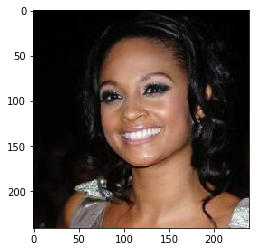

In [41]:
# load test image and take a look
test_file = trainDir + vggIdentityTrain.loc[888,'imageid']
print(test_file)
test_img = imread(test_file,as_gray=False)
print(test_img.shape)
plt.imshow(test_img);

In [42]:
lst = []
lst = np.zeros(shape=(1,224, 224, 3))
# add image to test batch
np.append(lst,np.array(load_data(test_file,(224,224))))
lst.shape

(1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


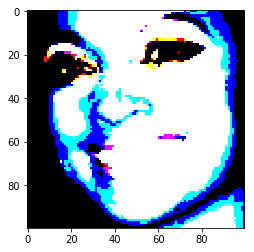

In [43]:
plt.imshow(load_data(test_file,(100,100)));

In [44]:
def image_encoding(model, facepaths, batch_size=32, feature_dim=512, chunks=1):
    print('==> compute image-level feature encoding.')
    num_faces = len(facepaths)
    face_feats = np.empty((num_faces, feature_dim))
    imgpaths = facepaths.tolist()
    #imgchunks = list(chunks(imgpaths, batch_size))
    imgchunks = [0,1]

    for c, imgs in enumerate(imgchunks):
        im_array = np.array([ut.load_data(path=i, shape=(224, 224, 3), mode='eval', augmentation=False) for i in imgs])
        f = model.predict(im_array, batch_size=batch_size)
        start = c * batch_size
        end = min((c + 1) * batch_size, num_faces)
        face_feats[start:end] = f
        if c % 500 == 0:
            print('-> finish encoding {}/{} images.'.format(c*batch_size, num_faces))
    return face_feats

In [47]:
# run model
#test = model.predict_generator(generator=testing_generator, use_multiprocessing=True, workers=6)
#face_feats = image_encoding(model, lst)
face_feats = model.predict(lst)
print(face_feats.dtype)
print(np.argmax(face_feats,axis=1))
print(face_feats[0].max())
print(vggIdentityTrain.loc[vggIdentityTrain.Class_ID.str.contains(str(np.argmax(face_feats,axis=1))),'Name'])

float32
[5458]
0.013194449
0          "Adam_Housley"
1          "Adam_Housley"
2          "Adam_Housley"
3          "Adam_Housley"
4          "Adam_Housley"
5          "Adam_Housley"
6          "Adam_Housley"
7          "Adam_Housley"
8          "Adam_Housley"
9          "Adam_Housley"
10         "Adam_Housley"
11         "Adam_Housley"
12         "Adam_Housley"
13         "Adam_Housley"
14         "Adam_Housley"
15         "Adam_Housley"
16         "Adam_Housley"
17         "Adam_Housley"
18         "Adam_Housley"
19         "Adam_Housley"
20         "Adam_Housley"
21         "Adam_Housley"
22         "Adam_Housley"
23         "Adam_Housley"
24         "Adam_Housley"
25         "Adam_Housley"
26         "Adam_Housley"
27         "Adam_Housley"
28         "Adam_Housley"
29         "Adam_Housley"
               ...       
39768     "Óscar_Jaenada"
39769     "Óscar_Jaenada"
39770     "Óscar_Jaenada"
39771     "Óscar_Jaenada"
39772     "Óscar_Jaenada"
39773     "Óscar_Jaenada"
39774     "

In [46]:
vggIdentityTrain.Class_ID.dtype

dtype('O')

In [91]:
def get_verification_label():
    # =============================================================
    # load meta information for template-to-template verification.
    # tid --> template id,  label --> 1/0
    # format:
    #           tid_1 tid_2 label
    # =============================================================
    print('==> get verification template pair and label.')
    tid_pair_path = 'vggface2_Keras/meta/ijbb_template_pair_label.txt'
    file = open(tid_pair_path, 'r')
    meta = file.readlines()
    Y, p1, p2 = [], [], []
    for m in meta:
        msplit = m.split()
        Y += [int(msplit[-1])]
        p1 += [int(msplit[0])]
        p2 += [int(msplit[1])]
    Y, p1, p2 = map(np.array, [Y, p1, p2])
    return Y, p1, p2

In [104]:
# Get the verification labels
Y, p1, p2 = get_verification_label()
print(Y.shape)
print(p1.shape)
print(p2.shape)

==> get verification template pair and label.
(8010270,)
(8010270,)
(8010270,)


## 2. Modify model via Feature Extraction and Fine Tuning (former is a must, second is optional but worth trying)

A few useful references:<br/>

**Replacing layers**<br/>

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751<br/>

https://www.tensorflow.org/alpha/tutorials/images/transfer_learning<br/>
* collab notebook at: 
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/images/transfer_learning.ipynb<br/>

https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/<br/>

https://github.com/tensorflow/tensorflow/issues/22479<br/>

**Similar project**<br/>

http://gigantes.ii.uam.es/fierrez/files/2018_CIARP_BiasFace_Acien.pdf

### 2.1 Feature Extraction (i.e. freeze convolutional base and add a new classification head)

In [ ]:
# 1) truncate model to obtain base
# 2) freeze base 
base_model.trainable = False

# check base_model
base_model.summary()

# 3) add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
# chain layers
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
# compile updated model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# train model

In [ ]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [ ]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

In [ ]:
# check learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 2.2 Fine tuning (i.e. unfreeze based model and set set bottom layers to be un-trainable)

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()